In [1]:
!pip install -U pytorch-lightning
!pip install comet-ml

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 412 kB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 162 kB 48.7 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 49.1 MB/s eta 0:00:01
     |████████████████████████████████| 499 kB 54.9 MB/s eta 0:00:01
     |████████████████████████████████| 140 kB 31.6 MB/s eta 0:00:01
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34545 sha256=d3f5db1989aded1da07b612118539263d1e445b780d2de5e3ee990546dd37c95
  Stored in directory: /tmp/pip-ephem-wheel-cache-_c9m7im6/wheels/34/2a/24/a490264ae9041fd48f778ff393526572c80bb498ddecb07ea5
Successfully built configobj
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Can't uninstall 'urllib3'. No files were found to uninstall.


In [2]:
import os
os.chdir("/notebooks")
from pytorch_lightning import LightningModule
import torch
import torch.nn as nn
import math
from base_lightning import Dataset
from torch.autograd import grad
import numpy as np
#from neptune.new.types import File
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.linear_model import LassoCV,Lasso, LinearRegression

import matplotlib.animation as animation
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor,TQDMProgressBar,EarlyStopping
from pytorch_lightning.loggers import CometLogger
from PIL import Image
import io


def gpu_prints():
    print("The total number of GPUs is:",torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print("GPU number",i,"is",torch.cuda.get_device_name(i))
        
gpu_prints()
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")


The total number of GPUs is: 1
GPU number 0 is Quadro P5000


In [3]:
class SinusoidalActivation(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.pi = torch.tensor([math.pi],dtype=torch.float32,device="cuda")
    
    def forward(self,input): 
        
        sinusoid = torch.sin(2*self.pi*input)
        return sinusoid

class NN(nn.Module):
    
    def __init__(self,hidden,init=False):
        
        super().__init__()
        self.init = init
        self.network = self.build_network(hidden,sigma=1)
        
    def forward(self, input_: torch.Tensor):
        
        input_ = input_.requires_grad_(True)
        return self.network(input_),input_

    def build_network(self,hidden,sigma):

        network= []
        first = nn.Linear(2,hidden)
        if self.init:
            print("Initing NN weights and baises")
            nn.init.normal_(first.weight,0,sigma**2)
            nn.init.zeros_(first.bias)
        network.append(first)
        network.append(SinusoidalActivation())
        
        second = nn.Linear(hidden,hidden)
        if self.init:
            torch.nn.init.xavier_uniform_(second.weight)
            torch.nn.init.zeros_(second.bias)
        network.append(second)
        network.append(nn.Tanh())
        
        third = nn.Linear(hidden,hidden)
        if self.init:
            torch.nn.init.xavier_uniform_(third.weight)
            torch.nn.init.zeros_(third.bias)
        network.append(third)
        network.append(nn.Tanh())
        
        fourth = nn.Linear(hidden,hidden)
        if self.init:
            torch.nn.init.xavier_uniform_(fourth.weight)
            torch.nn.init.zeros_(fourth.bias)
        network.append(fourth)
        network.append(nn.Tanh())
        
        fith = nn.Linear(hidden,hidden)
        if self.init:
            torch.nn.init.xavier_uniform_(fith.weight)
            torch.nn.init.zeros_(fith.bias)
        network.append(fith)
        network.append(nn.Tanh())
        
        sixth = nn.Linear(hidden,1)
        if self.init:
            torch.nn.init.xavier_uniform_(sixth.weight)
            torch.nn.init.zeros_(sixth.bias)
        network.append(sixth)
        network.append(nn.Tanh())
        
        network.pop()
        network = nn.Sequential(*network)
        
        return network 

In [4]:
class RegularNN(LightningModule):

    def __init__(self,filename,config,init_NN):

        super().__init__()
        
        self.data            = np.load(filename)
        a = filename.split('/')
        self.dir = a[0]
        self.filename = a[-1].split('.npz')[0]
        
        self.total_X         = torch.tensor(self.data["total_X"],dtype=torch.float32)
        self.total_X         = self.total_X[self.total_X[:,0]<=4]
        self.total_Y         = torch.tensor(self.data["total_Y"],dtype=torch.float32)
        self.total_Y         = self.total_Y[:self.total_X.shape[0]]


        self.X_train         = self.total_X[self.total_X[:,0]<=2]
        self.X_validation    = self.total_X[self.total_X[:,0]>=2]

        self.Y_train         = self.total_Y[self.total_X[:,0]<=2]
        self.Y_validation    = self.total_Y[self.total_X[:,0]>=2]

        self.c               = torch.tensor(self.data["c"],dtype=torch.float32)
        self.v               = torch.tensor(self.data["v"],dtype=torch.float32)
        self.total_x         = torch.tensor(self.data["X"],dtype=torch.float32)
        self.T               = torch.tensor(self.data["t"],dtype=torch.float32)
        self.T               = self.T[self.T<=4]

        self.U               = np.array(self.data["wave"])
        self.U               = self.U[:self.T.shape[0]]
        self.coefs           = self.data["coefs"]


        self.coiso              = None
        self.xi                 = None
        self.analytical_du2_dx2 = None
        self.lr                 = config["lr"]
        self.k_pde              = config["k_pde"]
        self.network            = custom_NN(n_in=2,n_hidden=6*[60],n_out=1,init=init_NN)
        
        self.first_coeff  = -(self.c**2-self.v**2)
        self.second_coeff = +2*self.v
        
        print("1st coef:",self.first_coeff)
        print("2nd coef:",self.second_coeff)
    
    def fig2img(self,fig):
        """Convert a Matplotlib figure to a PIL Image and return it"""
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        return img


    def forward(self,input_):

        return self.network(input_)

    def on_train_start(self):

        print("Device is:",self.device)
        fig,ax1 = plt.subplots(figsize=(20,7))
        extent = np.min(self.total_x.detach().cpu().numpy()), np.max(self.total_x.detach().cpu().numpy()), np.min(self.T.detach().cpu().numpy()), np.max(self.T.detach().cpu().numpy())
        im1 = plt.imshow(self.U,origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
        plt.colorbar()
        plt.xlabel("X")
        plt.ylabel("Time")
        plt.title(f"Real wave")
        image = self.fig2img(fig)
        self.logger.experiment.log_image(image,name="Real Wave")
        plt.close()

    def training_step(self, batch,batch_idx):

        #forward pass
        x,target = batch
        prediction,coordinates = self.forward(x)
        second_time_deriv,theta,term1,term2 = self.compute_derivatives(prediction,coordinates) # derivatives

        #self.xi = self.least_squares_QR(theta,second_time_deriv) #sparse vector computed using least squares
        self.xi = self.least_squares_SK(theta,second_time_deriv)
        
        #losses
        mse_loss                            = torch.mean((prediction-target)**2) # scalar
        pde_loss                            = torch.mean((second_time_deriv+term1+term2)**2)#should be scalar as well
        total_loss                          = mse_loss + self.k_pde*pde_loss

        #for i,j in enumerate(xi):
        #   self.log(f"Coefficient nr{i}",j,logger=True,on_epoch=True,on_step=False)
        
        self.log(f"Coefficient nr1",-self.xi[0],logger=True,on_epoch=True,on_step=False)
        self.log(f"Coefficient nr2",-self.xi[1],logger=True,on_epoch=True,on_step=False)
        self.log(f"Error in coefficient nr1",torch.abs((-self.xi[0]-self.first_coeff)/self.first_coeff)*100,logger=True,on_epoch=True,on_step=False)
        self.log(f"Error in coefficient nr2",torch.abs((-self.xi[1]-self.second_coeff)/self.second_coeff)*100,logger=True,on_epoch=True,on_step=False)
    
        self.log("MSE Loss",mse_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)
        self.log("PDE Loss",pde_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)
        self.log("Total Loss",total_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)

        return total_loss

    def validation_step(self,batch,batch_idx):

        x,target = batch
        val_prediction,val_coordinates = self.forward(x)
        val_loss = torch.mean((val_prediction-target)**2)
        self.log("Validation Loss",val_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)

    def compute_derivatives(self,prediction,coords,derivs=False):

        du = grad(outputs=prediction, inputs=coords, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
        first_time_deriv = du[:,0:1]
        du_dx            = du[:,1:2]
        
        du2 = grad(outputs=first_time_deriv,inputs=coords,grad_outputs=torch.ones_like(prediction),create_graph=True)[0]
        second_time_deriv = du2[:,0:1]
        du2_dtdx          = du2[:,1:2]
        
        
        du2_dx2 = grad(outputs=du_dx,inputs=coords,grad_outputs=torch.ones_like(prediction),create_graph=True)[0][:,1:2]

        #term1 = -(self.c**2-self.v**2)*du2_dx2
        #term2 = +2*self.v*du2_dtdx

        term1 = du2_dx2
        term2 = du2_dtdx
        

        theta = torch.reshape(torch.cat((term1,term2),dim=1),(prediction.shape[0],-1))

        if not derivs:

            return second_time_deriv,theta,term1,term2

        else:

            return second_time_deriv,du2_dtdx,du2_dx2

    def least_squares_QR(self,theta,second_deriv):

        Q,R = torch.linalg.qr(theta)
        xi  = torch.inverse(R) @ Q.T @ second_deriv
        return xi
    
    def least_squares_SK(self,theta,second_time_deriv):
        
        x,y = theta.detach().cpu().numpy(), second_time_deriv.detach().cpu().detach()
        coefs = LinearRegression().fit(x,y).coef_
        return coefs[0]
        
    
    def configure_optimizers(self):

        optimizer = torch.optim.AdamW(self.parameters(),lr=self.lr,amsgrad=True,weight_decay=1e-8)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(mode="min",factor=0.5,patience=500,threshold_mode="rel",threshold=1e-5)
        return optimizer

    def train_dataloader(self):

        dataset    = Dataset(data=self.X_train, labels=self.Y_train)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(self.X_train.shape[0]/6),drop_last=True, num_workers=0, shuffle=True)

        return dataloader

    def val_dataloader(self):

        val_dataset = Dataset(data=self.X_validation, labels=self.Y_validation)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=int(self.X_validation.shape[0]/6),
                                                     drop_last=True, num_workers=0, shuffle=False)
        
        return val_dataloader

    def analytical_derivs(self,x,time):

        if self.coiso is None:

            self.omega = np.zeros(self.coefs.shape[0])
            self.k_rev = np.zeros(self.coefs.shape[0])
            self.k_fwd = np.zeros(self.coefs.shape[0])
            self.phi   = np.zeros(self.coefs.shape[0])
            self.coiso = 1

            for i in range(self.coefs.shape[0]):

                n = i+1
                self.omega[i] = n*np.pi*(self.c**2-self.v**2)/self.c
                self.k_rev[i] = n*np.pi*(self.c+self.v)/self.c
                self.k_fwd[i] = n*np.pi*(self.c-self.v)/self.c
                self.phi[i]   = -n*(np.pi*(self.c+self.v)/(2*self.c)-np.pi/2)



        du2_dx2  = np.zeros((len(time),len(x)))
        du2_dxdt = np.zeros((len(time),len(x)))
        du2_dt2  = np.zeros((len(time),len(x)))

        for b,t in enumerate(time):

            sum1  = 0
            sum2  = 0
            sum3  = 0

            for n in range(self.coefs.shape[0]):

                C1     = self.coefs[n] * np.sin(self.k_fwd[n]*x - self.omega[n]*t - self.phi[n])
                C2     = self.coefs[n] * np.sin(self.k_rev[n]*x + self.omega[n]*t + self.phi[n])

                sum1 += -self.k_fwd[n]**2*C1 - self.k_rev[n]**2*C2
                sum2 += +self.k_fwd[n]*self.omega[n]*C1  - self.k_rev[n]*self.omega[n]*C2
                sum3 += -self.omega[n]**2*C1 - self.omega[n]**2*C2

            du2_dx2[b,:]  = sum1
            du2_dxdt[b,:] = sum2
            du2_dt2[b,:]  = sum3

        #this analytical derivatives should be [T,X]
        return du2_dx2,du2_dxdt,du2_dt2

    def plot(self):


        total_output = self.forward(self.total_X.to(self.device))[0].detach().cpu().numpy().reshape(self.T.shape[0],self.total_x.shape[0])
        fig,ax1 = plt.subplots(figsize=(20,7))
        extent = np.min(self.total_x.detach().cpu().numpy()), np.max(self.total_x.detach().cpu().numpy()), np.min(self.T.detach().cpu().numpy()), np.max(self.T.detach().cpu().numpy())
        im1 = plt.imshow(total_output,origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
        plt.colorbar()
        plt.xlabel("X")
        plt.ylabel("Time")
        plt.title(f"Full predicted wave at epoch {self.current_epoch}")
        image = self.fig2img(fig)
        self.logger.experiment.log_image(image,name=f"Full predicted wave")
        plt.close()


        fig,ax1 = plt.subplots(figsize=(20,7))
        extent = np.min(self.total_x.detach().cpu().numpy()), np.max(self.total_x.detach().cpu().numpy()), np.min(self.T.detach().cpu().numpy()), np.max(self.T.detach().cpu().numpy())
        im1 = plt.imshow(np.abs(total_output-self.U),origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
        plt.colorbar()
        plt.xlabel("X")
        plt.ylabel("Time")
        plt.title(f"Difference between true wave and predicted wave at epoch {self.current_epoch}")
        image = self.fig2img(fig)
        self.logger.experiment.log_image(image,name=f"Difference between true wave and predicted wave")
        plt.close()

    def anim(self):

        def init():
            for line in lines:
                line.set_data([],[])
            return lines

        fig = plt.figure(figsize=(15,5))
        ax = plt.axes(xlim=(0,1),ylim=(-3,3))
        line, = ax.plot([], [], lw=3)
        plt.xlim(0,1)
        plt.ylim(-3,3)
        plt.xlabel("X")
        plt.ylabel("Displacement")
        plt.title(f"Prediction for epoch {self.current_epoch}",fontsize=20)
        lines = []
        lobj1 = ax.plot([],[],lw=3,label="Predicted")[0]
        lobj2 = ax.plot([],[],lw=3,label="Real")[0]
        lines.append(lobj1)
        lines.append(lobj2)
        plt.legend()

        anim = FuncAnimation(fig,
                    self.update_plot,
                    init_func=init,
                    frames=int(len(self.T)),
                    fargs=(lines),
                     blit=True,
                    interval=100,
                    repeat=True)

        plt.legend()
        anim.save(f"{self.dir}/predictions/{self.filename}_epoch{self.current_epoch}_{now.minute}{now.second}" + ".gif",writer=PillowWriter(fps=24))
        #image = self.fig2img(anim)
        #self.logger.experiment.log_image(image,name=f"Prediction fig at {self.current_epoch}")
        plt.close()
        self.logger.experiment.log_image(f"{self.dir}/predictions/{self.filename}_epoch{self.current_epoch}_{now.minute}{now.second}" + ".gif",name=f"Prediction gif at {self.current_epoch}")

    def on_validation_epoch_end(self):
        
        self.plot()
        self.anim()
      
        """with torch.enable_grad():
            predictions,coordinates = self.forward(self.X_train.to(self.device))

            #analytical derivatives--> stay constant only need to compute 1 time
            if self.analytical_du2_dx2 == None:
                self.analy_du2_dx2,self.analy_du2_dxdt,self.analy_du2_dt2 = self.analytical_derivs(self.total_x,self.T[self.T<=2])

            #auto diff derivatives
            NN_du2_dt2,NN_du2_dxdt,NN_du2_dx2          = self.compute_derivatives(predictions,coordinates,derivs=True)

        NN_du2_dt2 = NN_du2_dt2.detach().cpu().numpy().reshape(-1,self.total_x.shape[0])
        NN_du2_dxdt= NN_du2_dxdt.detach().cpu().numpy().reshape(-1,self.total_x.shape[0])
        NN_du2_dx2 = NN_du2_dx2.detach().cpu().numpy().reshape(-1,self.total_x.shape[0])

        dif1 = 100 * np.median(np.abs((NN_du2_dt2[self.analy_du2_dt2>1e-5]  - self.analy_du2_dt2[self.analy_du2_dt2>1e-5])/self.analy_du2_dt2[self.analy_du2_dt2>1e-5]))
        dif2 = 100 * np.median(np.abs((NN_du2_dx2[self.analy_du2_dx2>1e-5]  - self.analy_du2_dx2[self.analy_du2_dx2>1e-5])/self.analy_du2_dx2[self.analy_du2_dx2>1e-5]))
        dif3 = 100 * np.median(np.abs((NN_du2_dxdt[self.analy_du2_dxdt>1e-5] - self.analy_du2_dxdt[self.analy_du2_dxdt>1e-5])/self.analy_du2_dxdt[self.analy_du2_dxdt>1e-5]))

        abs_dif1 = np.mean(np.abs(NN_du2_dt2 - self.analy_du2_dt2))
        abs_dif2 = np.mean(np.abs(NN_du2_dx2 - self.analy_du2_dx2))
        abs_dif3 = np.mean(np.abs(NN_du2_dxdt- self.analy_du2_dxdt))

        self.log("Absolute Diff1",abs_dif1,on_step=False,on_epoch=True,prog_bar=False,logger=True)
        self.log("Relative Diff1",dif1,on_step=False,on_epoch=True,prog_bar=False,logger=True)
        self.log("NN_du2_dt2",np.mean(np.abs(NN_du2_dt2)),on_step=False,on_epoch=True,logger=True,prog_bar=False)
        self.log("Analy_du2_dt2",np.mean(np.abs(self.analy_du2_dt2)),on_step=False,on_epoch=True,logger=True,prog_bar=False)

        self.log("Absolute Diff2",abs_dif2,on_step=False,on_epoch=True,prog_bar=False,logger=True)
        self.log("Relative Diff2",dif2,on_step=False,on_epoch=True,prog_bar=False,logger=True)
        self.log("NN_du2_dx2",np.mean(np.abs(NN_du2_dx2)),on_step=False,on_epoch=True,logger=True,prog_bar=False)
        self.log("Analy_du2_dx2",np.mean(np.abs(self.analy_du2_dx2)),on_step=False,on_epoch=True,logger=True,prog_bar=False)

        self.log("Absolute Diff3",abs_dif3,on_step=False,on_epoch=True,prog_bar=False,logger=True)
        self.log("Relative Diff3",dif3,on_step=False,on_epoch=True,prog_bar=False,logger=True)
        self.log("NN_du2_dxdt",np.mean(np.abs(NN_du2_dxdt)),on_step=False,on_epoch=True,logger=True,prog_bar=False)
        self.log("Analy_du2_dxdt",np.mean(np.abs(self.analy_du2_dxdt)),on_step=False,on_epoch=True,logger=True,prog_bar=False)"""

 

    def update_plot(self,i,line1,line2):

        a = self.forward(self.total_X.to(self.device))[0].detach().cpu().numpy()
        b   = a.reshape(self.T.shape[0],self.total_x.shape[0])
        line1.set_data(self.total_x,b[i,:])
        line2.set_data(self.total_x,self.U[i,:])
        lines = (line1,line2)

In [9]:
class PINN(LightningModule):

    def __init__(self,filename,config):

        super().__init__()
        
        self.data            = np.load(filename)
        a = filename.split('/')
        self.dir = a[0]
        self.filename = a[-1].split('.npz')[0]
        
        self.c               = torch.tensor(self.data["c"],dtype=torch.float32)
        self.v               = torch.tensor(self.data["v"],dtype=torch.float32)
        self.first_coeff  = -(self.c**2-self.v**2)
        self.second_coeff = +2*self.v
        self.total_x         = torch.tensor(self.data["X"],dtype=torch.float32)
        self.T               = torch.tensor(self.data["t"],dtype=torch.float32)
        self.T               = self.T[self.T<=4]
        
        self.U               = np.array(self.data["wave"])
        self.U               = self.U[:self.T.shape[0]]
        self.coefs           = self.data["coefs"]

        
        self.initial_xi         = None
        self.lr                 = config["lr"]
        self.k_pde              = config["k_pde"]
        self.k_mse              = config["k_mse"]
        self.network            = NN(init=False,hidden=30)
        
        
         
        self.total_X         = torch.tensor(self.data["total_X"],dtype=torch.float32)
        self.total_X         = self.total_X[self.total_X[:,0]<=4]
        self.total_Y         = torch.tensor(self.data["total_Y"],dtype=torch.float32)
        self.total_Y         = self.total_Y[:self.total_X.shape[0]]

        
        self.X1              = self.total_X[self.total_X[:,0]<=2]
        self.Y1              = self.total_Y[self.total_X[:,0]<=2]
        self.network.to("cuda:0")
 
        
       

        
        self.X_validation    = self.total_X[self.total_X[:,0]>=2]
        self.Y_validation    = self.total_Y[self.X_validation.shape[0]:]
        
        self.X_fixed_points  = self.X_validation[(self.X_validation[:,1]== 0)  |
                                                 (self.X_validation[:,1]== 0.1)|
                                                 #(self.X_validation[:,1]== 0.2)|
                                                 #(self.X_validation[:,1]== 0.3)|
                                                 #(self.X_validation[:,1]== 0.4)|
                                                 #(self.X_validation[:,1]== 0.5)|
                                                 #(self.X_validation[:,1]== 0.6)|
                                                 #(self.X_validation[:,1]== 0.7)|
                                                 #(self.X_validation[:,1]== 0.8)|
                                                 (self.X_validation[:,1]== 0.9)|
                                                 (self.X_validation[:,1]== 1)
                                                ]
        
        self.Y_fixed_points  = self.Y_validation[(self.X_validation[:,1]== 0) |
                                                 (self.X_validation[:,1]== 0.1)|
                                                 #(self.X_validation[:,1]== 0.2)|
                                                 #(self.X_validation[:,1]== 0.3)|
                                                 #(self.X_validation[:,1]== 0.4)|
                                                 #(self.X_validation[:,1]== 0.5)|
                                                 #(self.X_validation[:,1]== 0.6)|
                                                 #(self.X_validation[:,1]== 0.7)|
                                                 #(self.X_validation[:,1]== 0.8)|
                                                 (self.X_validation[:,1]== 0.9)|
                                                 (self.X_validation[:,1]== 1)
                                                 ]
        
        
        
        self.X_MSE           = self.X_fixed_points
        self.Y_MSE           = self.Y_fixed_points
        
    
        print("1st coef:",self.first_coeff)
        print("2nd coef:",self.second_coeff)

        
    def fig2img(self,fig):
        """Convert a Matplotlib figure to a PIL Image and return it"""
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        return img
        
    def forward(self,input_):
                
        return self.network(input_)
    
    def on_fit_start(self):      
        
        self.initial_xi = [1,1]
        aux1,aux2 = self.forward(self.X1.to(device='cuda:0'))
        second_time_deriv,theta,term1,term2 = self.compute_derivatives(aux1,aux2)
        self.initial_xi = self.least_squares_QR(theta,second_time_deriv).detach()
        print(self.initial_xi)
        
        fig,ax1 = plt.subplots(figsize=(20,7))
        extent = np.min(self.total_x.detach().cpu().numpy()), np.max(self.total_x.detach().cpu().numpy()), np.min(self.T.detach().cpu().numpy()), np.max(self.T.detach().cpu().numpy())
        im1 = plt.imshow(self.U,origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
        plt.colorbar()
        plt.xlabel("X")
        plt.ylabel("Time")
        plt.title(f"Real wave")
        image=self.fig2img(fig)
        self.logger.experiment.log_image(image,name="Real Wave")     
        self.anim()

    def training_step(self, batch,batch_idx):
        
        #forward pass
        batch1 = batch["mse"]
        batch2 = batch["pde"]

        x1,target1 = batch1
        x2,target2 = batch2

        prediction1,coordinates1 = self.forward(x1)
        prediction2,coordinates2 = self.forward(x2)

        second_time_deriv,theta,term1,term2 = self.compute_derivatives(prediction2,coordinates2)
        self.xi = self.least_squares_QR(theta,second_time_deriv)
        
        #losses
        mse_loss                            = torch.mean((prediction1-target1)**2) # scalar
        pde_loss                            = torch.mean((second_time_deriv-(term1+term2))**2)#should be scalar as well
        total_loss                          = self.k_mse*mse_loss  + self.k_pde*pde_loss


        self.log(f"Coefficient nr1",self.xi[0],logger=True,on_epoch=True,on_step=False)
        self.log(f"Coefficient nr2",self.xi[1],logger=True,on_epoch=True,on_step=False)
        self.log(f"Error in coefficient nr1",torch.abs((self.xi[0]-self.first_coeff)/self.first_coeff)*100,logger=True,on_epoch=True,on_step=False)
        self.log(f"Error in coefficient nr2",torch.abs((self.xi[1]-self.second_coeff)/self.second_coeff)*100,logger=True,on_epoch=True,on_step=False)
    
        self.log("MSE Loss",mse_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)
        self.log("PDE Loss",pde_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)
        self.log("Total Loss",total_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)      
        
        return total_loss

    def validation_step(self,batch,batch_idx):

        x,target = batch
        val_prediction,val_coordinates = self.forward(x)
        val_loss = torch.mean((val_prediction-target)**2)
        self.log("Validation Loss",val_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)


    def compute_derivatives(self,prediction,coords,derivs=False):
        
        du = grad(outputs=prediction, inputs=coords, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
        first_time_deriv = du[:,0:1]
        du_dx            = du[:,1:2]

        du2 = grad(outputs=first_time_deriv,inputs=coords,grad_outputs=torch.ones_like(prediction),create_graph=True)[0]
        second_time_deriv = du2[:,0:1]
        du2_dtdx          = du2[:,1:2]

        du2_dx2 = grad(outputs=du_dx,inputs=coords,grad_outputs=torch.ones_like(prediction),create_graph=True)[0][:,1:2]

        term1 = self.initial_xi[0]*du2_dx2
        term2 = self.initial_xi[1]*du2_dtdx

        theta = torch.reshape(torch.cat((term1,term2),dim=1),(prediction.shape[0],-1))

        if not derivs:

            return second_time_deriv,theta,term1,term2

        else:

            return second_time_deriv,du2_dtdx,du2_dx2


        
    def least_squares_QR(self,theta,second_deriv):

        Q,R = torch.linalg.qr(theta)
        xi  = torch.inverse(R) @ Q.T @ second_deriv
        return xi
    
    def configure_optimizers(self):

        optimizer = torch.optim.AdamW(self.parameters(),lr=self.lr,amsgrad=True,weight_decay=1e-8)

        return optimizer

    def train_dataloader(self):

        dataset1   = Dataset(data=self.X_MSE, labels=self.Y_MSE)
        dataset2   = Dataset(data=self.X_validation,labels = self.Y_validation)

        dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=int(self.X_MSE.shape[0]/4),drop_last=True, shuffle=True,num_workers=0)
        dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=int(self.X_validation.shape[0]/4),drop_last=True,shuffle=True,num_workers=0)



        return {"mse":dataloader1,"pde":dataloader2}

    def val_dataloader(self):

        val_dataset = Dataset(data=self.X_validation, labels=self.Y_validation)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=int(self.X_validation.shape[0]/4),
                                                     drop_last=True, num_workers=0, shuffle=False)

        return val_dataloader

    def plot(self):

        
        total_output = self.forward(self.total_X.to(self.device))[0].detach().cpu().numpy().reshape(self.T.shape[0],self.total_x.shape[0])
        fig,ax1 = plt.subplots(figsize=(20,7))
        extent = np.min(self.total_x.detach().cpu().numpy()), np.max(self.total_x.detach().cpu().numpy()), np.min(self.T.detach().cpu().numpy()), np.max(self.T.detach().cpu().numpy())
        im1 = plt.imshow(total_output,origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
        plt.colorbar()
        plt.xlabel("X")
        plt.ylabel("Time")
        image = self.fig2img(fig)
        self.logger.experiment.log_image(image,name=f"Full predicted wave")
        plt.close()
        
        
        fig,ax1 = plt.subplots(figsize=(20,7))
        extent = np.min(self.total_x.detach().cpu().numpy()), np.max(self.total_x.detach().cpu().numpy()), np.min(self.T.detach().cpu().numpy()), np.max(self.T.detach().cpu().numpy())
        im1 = plt.imshow(np.abs(total_output-self.U),origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
        plt.colorbar()
        plt.xlabel("X")
        plt.ylabel("Time")
        plt.title(f"Difference between true wave and predicted wave at epoch {self.current_epoch}")
        image = self.fig2img(fig)
        self.logger.experiment.log_image(image,name=f"Difference between true wave and predicted wave")
        plt.close()
    
    def anim(self):
        
        def init():
            for line in lines:
                line.set_data([],[])
            return lines

        fig = plt.figure(figsize=(15,5))
        ax = plt.axes(xlim=(0,1),ylim=(-3,3))
        line, = ax.plot([], [], lw=3)
        plt.xlim(0,1)
        plt.ylim(-3,3)
        plt.xlabel("X")
        plt.ylabel("Displacement")
        plt.title(f"Prediction for epoch {self.current_epoch}",fontsize=20)
        lines = []
        lobj1 = ax.plot([],[],lw=3,label="Predicted")[0]
        lobj2 = ax.plot([],[],lw=3,label="Real")[0]
        lines.append(lobj1)
        lines.append(lobj2)
        plt.legend()
        
        
        anim = FuncAnimation(fig,
                    self.update_plot,
                    init_func=init,
                    frames=int(len(self.T)),
                    fargs=(lines),
                     blit=True,
                    interval=100,
                    repeat=True)
        
        plt.legend()
        writergif = animation.PillowWriter(fps=30)

        anim.save(f"predictions/{self.filename}_epoch{self.current_epoch}_{now.minute}{now.second}" + ".gif",writer="ffmpeg")
        plt.close()
        self.logger.experiment.log_image(f"predictions/{self.filename}_epoch{self.current_epoch}_{now.minute}{now.second}" + ".gif",name=f"Prediction gif at {self.current_epoch}")
    
    def update_plot(self,i,line1,line2):
        
        a = self.forward(self.total_X.to(self.device))[0].detach().cpu().numpy()
        b   = a.reshape(self.T.shape[0],self.total_x.shape[0])
        line1.set_data(self.total_x,b[i,:])
        line2.set_data(self.total_x,self.U[i,:])
        lines = (line1,line2)
        
        return lines    
    
    def on_validation_epoch_end(self):
        
        self.plot()
        self.anim()
    
        

In [10]:
from pytorch_lightning.callbacks import ModelCheckpoint


def training(filename,PATH):
    
    print(filename)
    save_name = filename.split("/")[-1]
    save_name = save_name.split(".npz")[0]

    config = {
        "lr": 1e-3,
        "filename":filename,
        "k_pde":1e-4,
        "k_mse":10,
        "PATH":PATH
    } 
    
    model = PINN(filename=filename,config=config)
    model.load_from_checkpoint(filename=filename,config=config,checkpoint_path=config["PATH"])
    model.to("cuda:0")
    print(model)
    

    comet_logger = CometLogger(
        api_key="kZhkiprqabfgQqOTbHNHpOJvf",
        workspace="jose-bastos",
        project_name="temp_pinn"  # Optional
    )

    comet_logger.log_hyperparams(config)
    
    epochs = 20
    epochs = epochs*10**3+1
    kwargs = {"max_epochs":epochs ,
              "accelerator": "gpu",
              "devices":1,
              "num_sanity_val_steps": 0,
              "logger": comet_logger,
              "check_val_every_n_epoch":1000,
              "enable_checkpointing":False,
              "enable_progress_bar":False
             }

    trainer = Trainer(**kwargs,resume_from_checkpoint=config["PATH"])
    trainer.fit(model)
    trainer.save_checkpoint(f"resolution/models/PINNs/temporal/{save_name}_{epochs}k_.ckpt")

    
    comet_logger.experiment.end()

In [8]:
filename = "resolution/data/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.005_dx=0.040.npz"
path_ = "resolution/models/NN/spatial/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.050_15000.ckpt"
training(filename=filename,PATH=path_)

resolution/data/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.005_dx=0.040.npz


CometLogger will be initialized in online mode
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


1st coef: tensor(-0.7500)
2nd coef: tensor(1.)
1st coef: tensor(-0.7500)
2nd coef: tensor(1.)
PINN(
  (network): NN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): SinusoidalActivation()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Tanh()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): Tanh()
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): Tanh()
      (8): Linear(in_features=50, out_features=50, bias=True)
      (9): Tanh()
      (10): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)



KeyboardInterrupt



CometLogger will be initialized in online mode
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


resolution/data/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.100_dx=0.040.npz
1st coef: tensor(-0.7500)
2nd coef: tensor(1.)
1st coef: tensor(-0.7500)
2nd coef: tensor(1.)
PINN(
  (network): NN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=30, bias=True)
      (1): SinusoidalActivation()
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=30, bias=True)
      (5): Tanh()
      (6): Linear(in_features=30, out_features=30, bias=True)
      (7): Tanh()
      (8): Linear(in_features=30, out_features=30, bias=True)
      (9): Tanh()
      (10): Linear(in_features=30, out_features=1, bias=True)
    )
  )
)


COMET INFO: Experiment is live on comet.com https://www.comet.com/jose-bastos/temp-pinn/82b31efc9a404b6092d0cff623e48cd1

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:52: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:731: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v2.0. Specify the fit checkpoint path with `trainer.fit(ckpt_path=)` instead.
  ckpt_path = ckpt_path or self.resume_from_checkpoint
Restoring states from the checkpoint path at resolution/models/NN/temporal2/c=1_v=0.5c_noise=0_mo

tensor([[ 0.6846],
        [-0.8782]], device='cuda:0')


MovieWriter ffmpeg unavailable; using Pillow instead.
Restored all states from the checkpoint file at resolution/models/NN/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.100_dx=0.040_15k.ckpt
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning

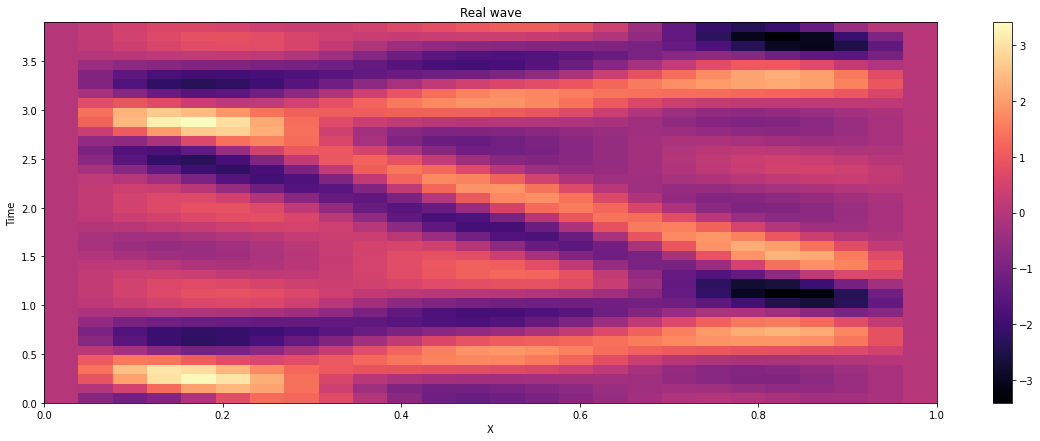

In [11]:
paths = ["resolution/models/NN/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.100_dx=0.040_15k.ckpt",
         "resolution/models/NN/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.020_dx=0.040_15k.ckpt",
         "resolution/models/NN/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.040_15k.ckpt",
         "resolution/models/NN/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.005_dx=0.040_15k.ckpt"]
         
files = ["resolution/data/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.100_dx=0.040.npz",
         "resolution/data/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.020_dx=0.040.npz",
         "resolution/data/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.040.npz",
         "resolution/data/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.005_dx=0.040.npz",
         "resolution/data/temporal2/c=1_v=0.5c_noise=0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.001_dx=0.040.npz"]

for i in range(len(files)):
    training(filename = files[i],PATH=paths[i])